In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csav)

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

import os
print("done")

done


In [ ]:
import os

# Replace 'Your_File_Path' with the path to your zip file in Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks'

os.chdir(file_path)


In [4]:
Ravdess = pd.DataFrame({
    'emotions': [],
    'path': []
})

scaler = MinMaxScaler(feature_range=(0,1))

Ravdess_dir = "Datasets/RAVDESS/audio_speech_actors_01-24/"
for dir in os.listdir(Ravdess_dir):
    for file in os.listdir(Ravdess_dir + dir):
        audio_path = Ravdess_dir + dir + '/' + file
        id_arr = file.split('-')
        emo_id = id_arr[2]
        if (emo_id == '01'):
            emo = 'neutral'
        elif (emo_id == '02'):
            emo = 'calm'
        elif (emo_id == '03'):
            emo = 'happy'
        elif (emo_id == '04'):
            emo = 'sad'
        elif (emo_id == '05'):
            emo = 'angry'
        elif (emo_id == '06'):
            emo = 'fearful'
        elif (emo_id == '07'):
            emo = 'disgust'
        else:
            emo = 'surprised'
        new_data = pd.DataFrame({'emotions': [emo], 'path': [audio_path]})
        Ravdess = pd.concat([Ravdess, new_data], ignore_index=True)
Ravdess['emotions'] = pd.Categorical(Ravdess['emotions'])
Ravdess

,emotions,path
0,disgust,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
2,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
3,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
4,happy,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
...,...,...
1435,sad,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1436,calm,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1437,surprised,Datasets/RAVDESS/audio_speech_actors_01-24/Act...
1438,fearful,Datasets/RAVDESS/audio_speech_actors_01-24/Act...


In [5]:
Ravdess['emotions'].value_counts()

emotions
angry        192
calm         192
disgust      192
fearful      192
happy        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64

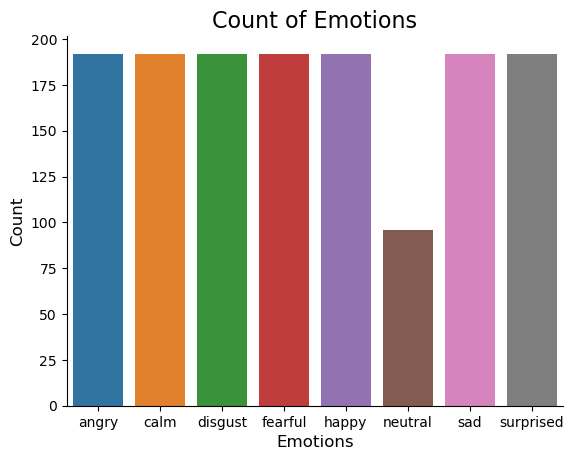

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=Ravdess, x='emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
TESS = pd.DataFrame ({
    'emotions': [],
    'path':[]
})
TESS_dir = "Datasets/TESS"


for dirname, _, filenames in os.walk('Datasets/TESS'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

        audio_path = os.path.join (dirname,filename)
        emo = filename.split('_')[-1]
        emo_tag = emo.split('.')[0]

        if emo_tag == 'fear':
            emo = 'fearful'
        elif emo_tag == 'ps':
            emo = 'surprised'
        elif emo_tag == 'sad':
            emo = 'sad'
        elif emo_tag == 'happy':
            emo = 'happy'
        elif emo_tag == 'neutral':
            emo = 'neutral'
        elif emo_tag == 'angry':
            emo = 'angry'
        elif emo_tag == 'disgust':
            emo = 'disgust'

        new_data = pd.DataFrame({'emotions': [emo], 'path': [audio_path]})
        TESS = pd.concat([TESS, new_data], ignore_index=True)
    if len(TESS) == 2800:
        break

TESS['emotions'] = pd.Categorical (TESS['emotions'])
TESS

,emotions,path
0,disgust,Datasets/TESS/TESS Toronto emotional speech se...
1,disgust,Datasets/TESS/TESS Toronto emotional speech se...
2,disgust,Datasets/TESS/TESS Toronto emotional speech se...
3,disgust,Datasets/TESS/TESS Toronto emotional speech se...
4,disgust,Datasets/TESS/TESS Toronto emotional speech se...
...,...,...
2795,fearful,Datasets/TESS/TESS Toronto emotional speech se...
2796,fearful,Datasets/TESS/TESS Toronto emotional speech se...
2797,fearful,Datasets/TESS/TESS Toronto emotional speech se...
2798,fearful,Datasets/TESS/TESS Toronto emotional speech se...


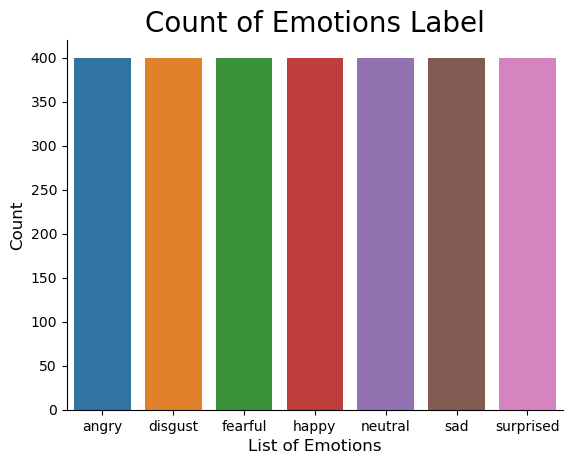

In [8]:
plt.title ("Count of Emotions Label",fontsize = 20)
sns.countplot (data=TESS, x ='emotions')
plt.xlabel ('List of Emotions',fontsize = 12)
plt.ylabel ('Count',fontsize = 12)
sns.despine (top=True, right = True,left =False,bottom=False)
plt.show ()

In [9]:
def create_wave_plot (data_path, emo):
    audio, sr = librosa.load(data_path)
    plt.figure(figsize=(10,3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=16)
    librosa.display.waveshow(audio, sr=sr)
    plt.show()

def show_melspectrogram (data_path, emo):
    S_db, sr = create_melspectrogram (data_path)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, y_axis='mel', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for audio with {emo} emotion')
    plt.tight_layout()
    plt.show()

def create_melspectrogram (data_path):
    audio, sr = librosa.load(data_path, sr=22050)
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    S = librosa.feature.melspectrogram(y=audio_cut, sr=sr, n_mels=128, n_fft=1024, hop_length=512)
    S_db =librosa.power_to_db(S, ref=np.min)
    return S_db, sr

def create_mfcc (audio, sr):
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    feature = np.mean(librosa.feature.mfcc(y=audio_cut,sr=sr,n_mfcc=40).T,axis=0)
    return feature

def create_origin_mfcc (data_path):
    S, sr = librosa.load(data_path)
    feature = create_mfcc(S,sr)
    return feature

def create_noise_mfcc (data_path):
    S, sr = librosa.load(data_path)
    noise_amp = 0.035*np.random.uniform()*np.amax(S)
    S = S + noise_amp*np.random.normal(size=S.shape[0])
    feature = create_mfcc(S,sr)
    return feature

def create_pitch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.pitch_shift(y=S, sr=sr, n_steps=0.7)
    feature = create_mfcc(S,sr)
    return feature

def create_stretch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.time_stretch(y=S, rate=0.85)
    feature = create_mfcc(S,sr)
    return feature

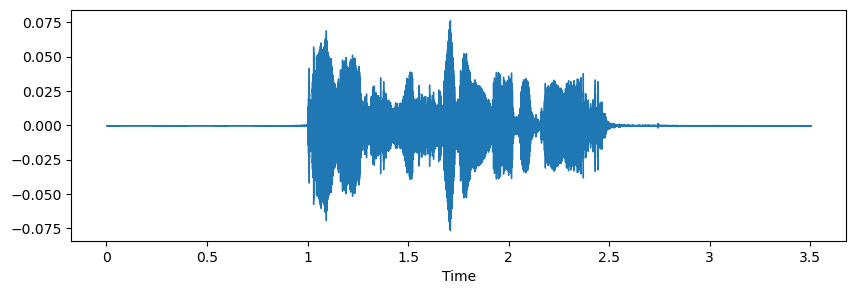

In [10]:
path_happy = np.array(Ravdess.path[Ravdess.emotions=='happy'])[1]
S, sr = librosa.load(path_happy)
plt.figure(figsize=(10,3))
librosa.display.waveshow(S, sr=sr)
plt.show()

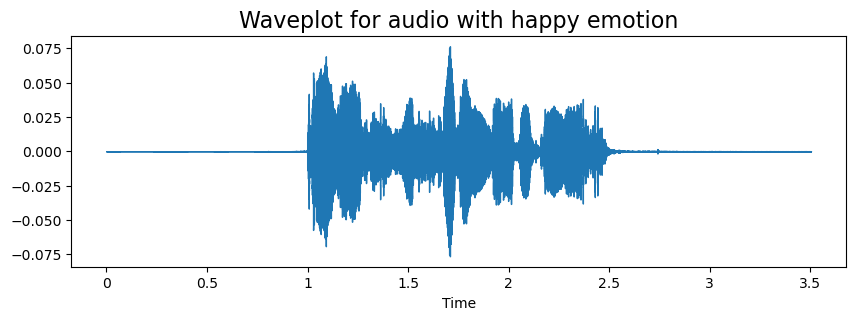

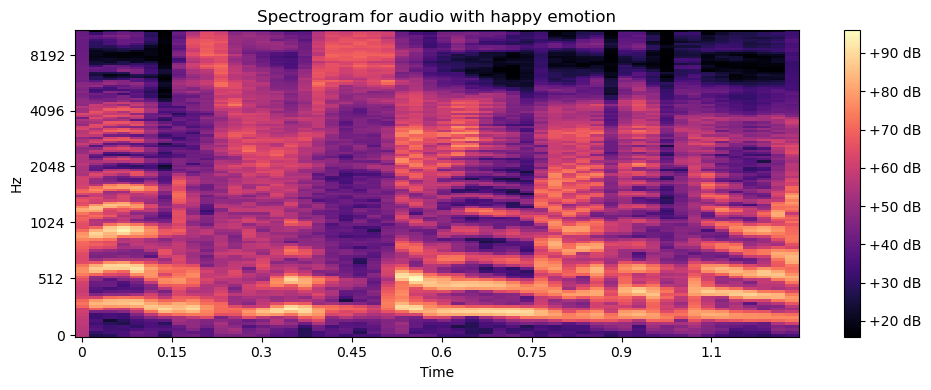

In [11]:
path_happy = np.array(Ravdess.path[Ravdess.emotions=='happy'])[1]
create_wave_plot(path_happy, 'happy')
show_melspectrogram(path_happy, 'happy')

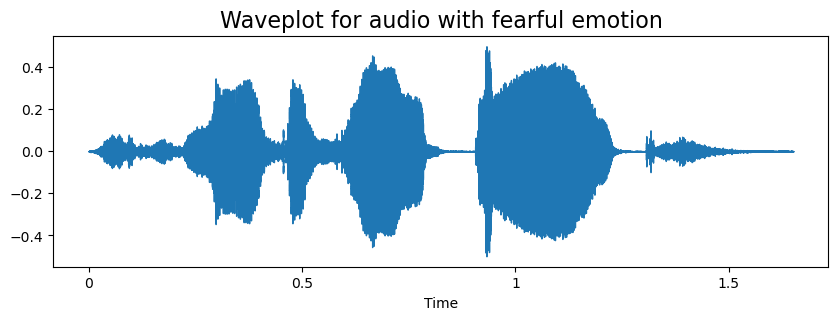

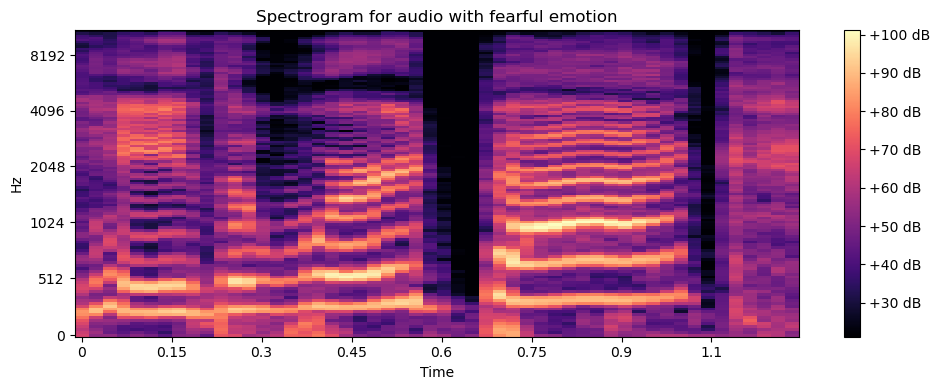

In [12]:
path_fearful = np.array (TESS.path[TESS.emotions=='fearful'])[1]
create_wave_plot (path_fearful, 'fearful')
show_melspectrogram (path_fearful, 'fearful')

In [13]:
df = pd.concat([Ravdess, TESS], axis=0, ignore_index=True)
df = df[df['emotions'] != 'calm']

In [14]:
groups = df.groupby('emotions')
groups.size()

emotions
angry        592
disgust      592
fearful      592
happy        592
neutral      496
sad          592
surprised    592
dtype: int64

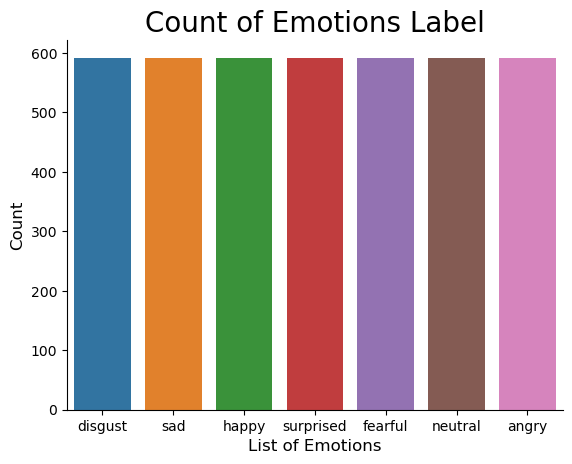

In [15]:
#Sinh thêm dữ liệu với nhãn neutral
neutral_df = df[df['emotions'] == 'neutral']
random_neutral = neutral_df.sample (n=groups.size().max()-groups.size().min())
df = pd.concat([df,random_neutral],ignore_index=True)
plt.title ("Count of Emotions Label",fontsize = 20)
sns.countplot (data=df, x ='emotions')
plt.xlabel ('List of Emotions',fontsize = 12)
plt.ylabel ('Count',fontsize = 12)
sns.despine (top=True, right = True,left =False,bottom=False)
plt.show ()

In [16]:
origin = df['path'].apply(lambda x:create_origin_mfcc(x))
noise = df['path'].apply(lambda x:create_noise_mfcc(x))
pitch = df['path'].apply(lambda x:create_pitch_mfcc(x))
stretch = df['path'].apply(lambda x:create_stretch_mfcc(x))

In [17]:
ohe= OneHotEncoder()
y1 = ohe.fit_transform( df[['emotions']] )
y1 = y1.toarray()
y2 = ohe.fit_transform( df[['emotions']] )
y2 = y2.toarray()
y3 = ohe.fit_transform( df[['emotions']] )
y3 = y3.toarray()
y4 = ohe.fit_transform( df[['emotions']] )
y4 = y4.toarray()
mfcc_data = np.concatenate([origin, noise, pitch, stretch])
y = np.concatenate([y1,y2,y3,y4])
y.shape

(16576, 7)

In [18]:
X = [x for x in mfcc_data]
X = np.array(X)
X.shape

(16576, 40)

In [ ]:
#X=np.expand_dims(X,-1)
#X.shape

In [19]:
y_label = list ()
for i in range (len(y)):
    if y[i][0] == 1.0:
        y_label.append ('angry')
    elif y[i][1] == 1.0:
        y_label.append ('disgust')
    elif y[i][2] == 1.0:
        y_label.append ('fearful')
    elif y[i][3] == 1.0:
        y_label.append ('happy')
    elif y[i][4] == 1.0:
        y_label.append ('neutral')
    elif y[i][5] == 1.0:
        y_label.append ('sad')
    elif y[i][6] == 1.0:
        y_label.append ('suprised')

y_trans = np.array (y_label)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y_trans,test_size=0.2,random_state=42)

In [22]:
X_train.shape

(13260, 40)

In [ ]:
#Train model using SVM
model_SVM = SVC (C=1.0,kernel='rbf',random_state=42)
model_SVM.fit (X_train,y_train)

y_pred = model_SVM.predict (X_test)

print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.79      0.78       477
     disgust       0.58      0.78      0.67       465
     fearful       0.81      0.78      0.79       463
       happy       0.77      0.60      0.68       478
     neutral       0.94      0.84      0.88       479
         sad       0.83      0.76      0.79       473
    suprised       0.67      0.72      0.69       481

    accuracy                           0.75      3316
   macro avg       0.77      0.75      0.75      3316
weighted avg       0.77      0.75      0.75      3316



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.24%


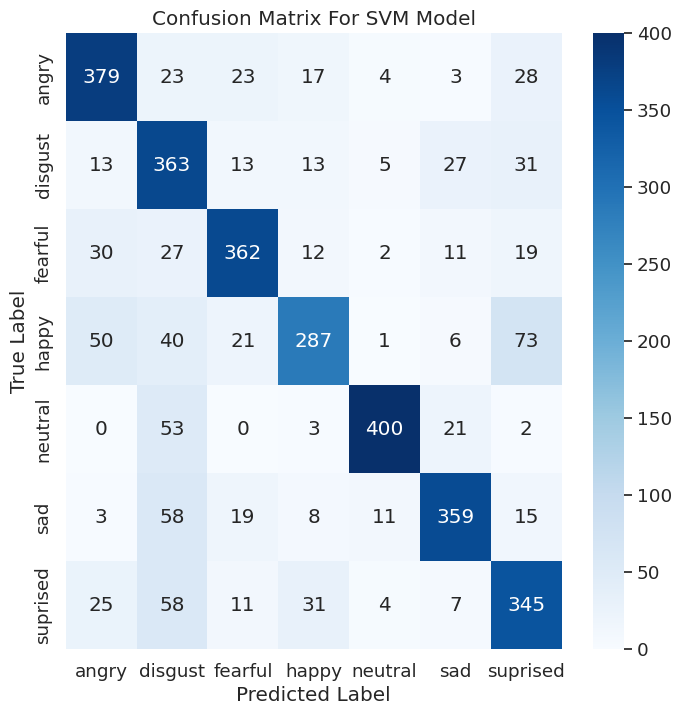

In [ ]:
#Visualize Confusion Matrix For SVM model
result_cf = confusion_matrix (y_test,y_pred)
sns.set (font_scale=1.2)
plt.figure(figsize=(8,8))
label_name = np.unique(y_test)
sns.heatmap (result_cf,annot=True,cmap='Blues',fmt='g',xticklabels=label_name, yticklabels=label_name)
sns.set (font_scale=1.2)

plt.title ('Confusion Matrix For SVM Model')
plt.xlabel ('Predicted Label')
plt.ylabel ('True Label')
plt.show ()